In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

# Positional Encoding

## Problème
L'attention n'a pas de notion de position! "Le chat mange la souris" et "La souris mange le chat" auraient la même représentation.

## Solution
Ajouter des informations de position à chaque token via le **Positional Encoding**.

## Formules
$$PE_{(pos, 2i)} = \sin\left(\frac{pos}{10000^{2i/d_{model}}}\right)$$
$$PE_{(pos, 2i+1)} = \cos\left(\frac{pos}{10000^{2i/d_{model}}}\right)$$

In [2]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

## 1. Construction pas à pas

In [3]:
# Paramètres
max_sequence_length = 10
d_model = 6

print(f"Longueur max de séquence: {max_sequence_length}")
print(f"Dimension du modèle: {d_model}")

Longueur max de séquence: 10
Dimension du modèle: 6


### Étape 1: Créer les indices pairs (even)

In [4]:
# Indices pairs: 0, 2, 4, ...
even_i = torch.arange(0, d_model, 2).float()

print("Indices pairs (even_i):")
print(even_i)
print(f"Shape: {even_i.shape}")

Indices pairs (even_i):
tensor([0., 2., 4.])
Shape: torch.Size([3])


### Étape 2: Calculer le dénominateur

In [5]:
# Dénominateur: 10000^(2i/d_model)
denominator = torch.pow(10000, even_i / d_model)

print("Dénominateur pour chaque dimension:")
print(denominator)
print(f"\nLes fréquences diminuent pour les dimensions supérieures")

Dénominateur pour chaque dimension:
tensor([  1.0000,  21.5443, 464.1590])

Les fréquences diminuent pour les dimensions supérieures


### Étape 3: Créer les positions

In [6]:
# Positions: 0, 1, 2, ..., max_sequence_length-1
position = torch.arange(max_sequence_length).reshape(max_sequence_length, 1).float()

print("Positions:")
print(position)
print(f"Shape: {position.shape}")

Positions:
tensor([[0.],
        [1.],
        [2.],
        [3.],
        [4.],
        [5.],
        [6.],
        [7.],
        [8.],
        [9.]])
Shape: torch.Size([10, 1])


### Étape 4: Calcul des encodages pairs (sin)

In [7]:
# PE pour indices pairs: sin(position / denominator)
even_PE = torch.sin(position / denominator)

print("Positional Encoding (indices pairs - sin):")
print(even_PE)
print(f"Shape: {even_PE.shape}")

Positional Encoding (indices pairs - sin):
tensor([[ 0.0000,  0.0000,  0.0000],
        [ 0.8415,  0.0464,  0.0022],
        [ 0.9093,  0.0927,  0.0043],
        [ 0.1411,  0.1388,  0.0065],
        [-0.7568,  0.1846,  0.0086],
        [-0.9589,  0.2300,  0.0108],
        [-0.2794,  0.2749,  0.0129],
        [ 0.6570,  0.3192,  0.0151],
        [ 0.9894,  0.3629,  0.0172],
        [ 0.4121,  0.4057,  0.0194]])
Shape: torch.Size([10, 3])


### Étape 5: Calcul des encodages impairs (cos)

In [8]:
# PE pour indices impairs: cos(position / denominator)
odd_PE = torch.cos(position / denominator)

print("Positional Encoding (indices impairs - cos):")
print(odd_PE)
print(f"Shape: {odd_PE.shape}")

Positional Encoding (indices impairs - cos):
tensor([[ 1.0000,  1.0000,  1.0000],
        [ 0.5403,  0.9989,  1.0000],
        [-0.4161,  0.9957,  1.0000],
        [-0.9900,  0.9903,  1.0000],
        [-0.6536,  0.9828,  1.0000],
        [ 0.2837,  0.9732,  0.9999],
        [ 0.9602,  0.9615,  0.9999],
        [ 0.7539,  0.9477,  0.9999],
        [-0.1455,  0.9318,  0.9999],
        [-0.9111,  0.9140,  0.9998]])
Shape: torch.Size([10, 3])


### Étape 6: Entrelacement (interleaving)

In [9]:
# Stack: combiner even et odd
stacked = torch.stack([even_PE, odd_PE], dim=2)
print(f"Après stack: {stacked.shape}")

# Flatten: entrelacer
PE = torch.flatten(stacked, start_dim=1, end_dim=2)

print(f"\nPositional Encoding final:")
print(PE)
print(f"Shape: {PE.shape}")
print(f"\n✓ Encodage pour {max_sequence_length} positions, {d_model} dimensions")

Après stack: torch.Size([10, 3, 2])

Positional Encoding final:
tensor([[ 0.0000,  1.0000,  0.0000,  1.0000,  0.0000,  1.0000],
        [ 0.8415,  0.5403,  0.0464,  0.9989,  0.0022,  1.0000],
        [ 0.9093, -0.4161,  0.0927,  0.9957,  0.0043,  1.0000],
        [ 0.1411, -0.9900,  0.1388,  0.9903,  0.0065,  1.0000],
        [-0.7568, -0.6536,  0.1846,  0.9828,  0.0086,  1.0000],
        [-0.9589,  0.2837,  0.2300,  0.9732,  0.0108,  0.9999],
        [-0.2794,  0.9602,  0.2749,  0.9615,  0.0129,  0.9999],
        [ 0.6570,  0.7539,  0.3192,  0.9477,  0.0151,  0.9999],
        [ 0.9894, -0.1455,  0.3629,  0.9318,  0.0172,  0.9999],
        [ 0.4121, -0.9111,  0.4057,  0.9140,  0.0194,  0.9998]])
Shape: torch.Size([10, 6])

✓ Encodage pour 10 positions, 6 dimensions


## 2. Visualisation du Positional Encoding

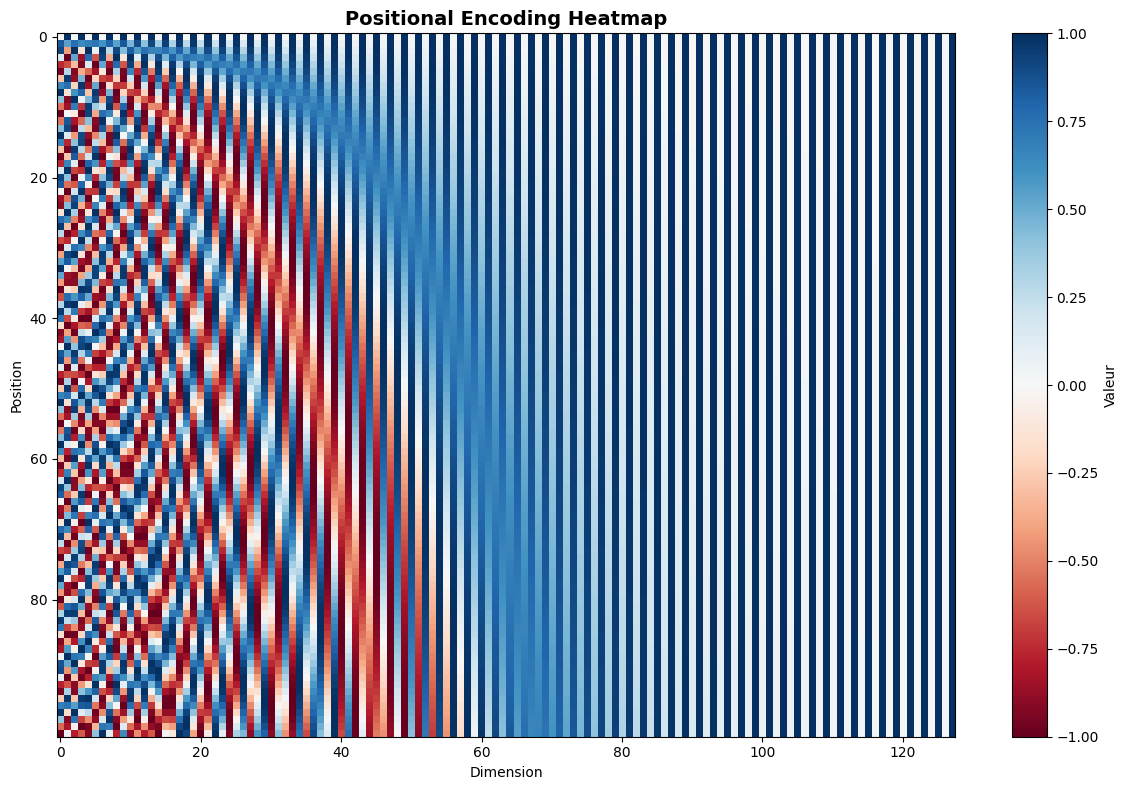

Observation: Les patterns varient selon la dimension et la position


In [10]:
# Créer un PE plus grand pour mieux visualiser
max_len = 100
d_model_viz = 128

even_i = torch.arange(0, d_model_viz, 2).float()
denominator = torch.pow(10000, even_i / d_model_viz)
position = torch.arange(max_len).reshape(max_len, 1).float()

even_PE = torch.sin(position / denominator)
odd_PE = torch.cos(position / denominator)
stacked = torch.stack([even_PE, odd_PE], dim=2)
PE_viz = torch.flatten(stacked, start_dim=1, end_dim=2)

# Heatmap
plt.figure(figsize=(12, 8))
plt.imshow(PE_viz.numpy(), cmap='RdBu', aspect='auto')
plt.colorbar(label='Valeur')
plt.title('Positional Encoding Heatmap', fontsize=14, fontweight='bold')
plt.xlabel('Dimension')
plt.ylabel('Position')
plt.tight_layout()
plt.show()

print("Observation: Les patterns varient selon la dimension et la position")

## 3. Visualisation des ondes sinusoïdales

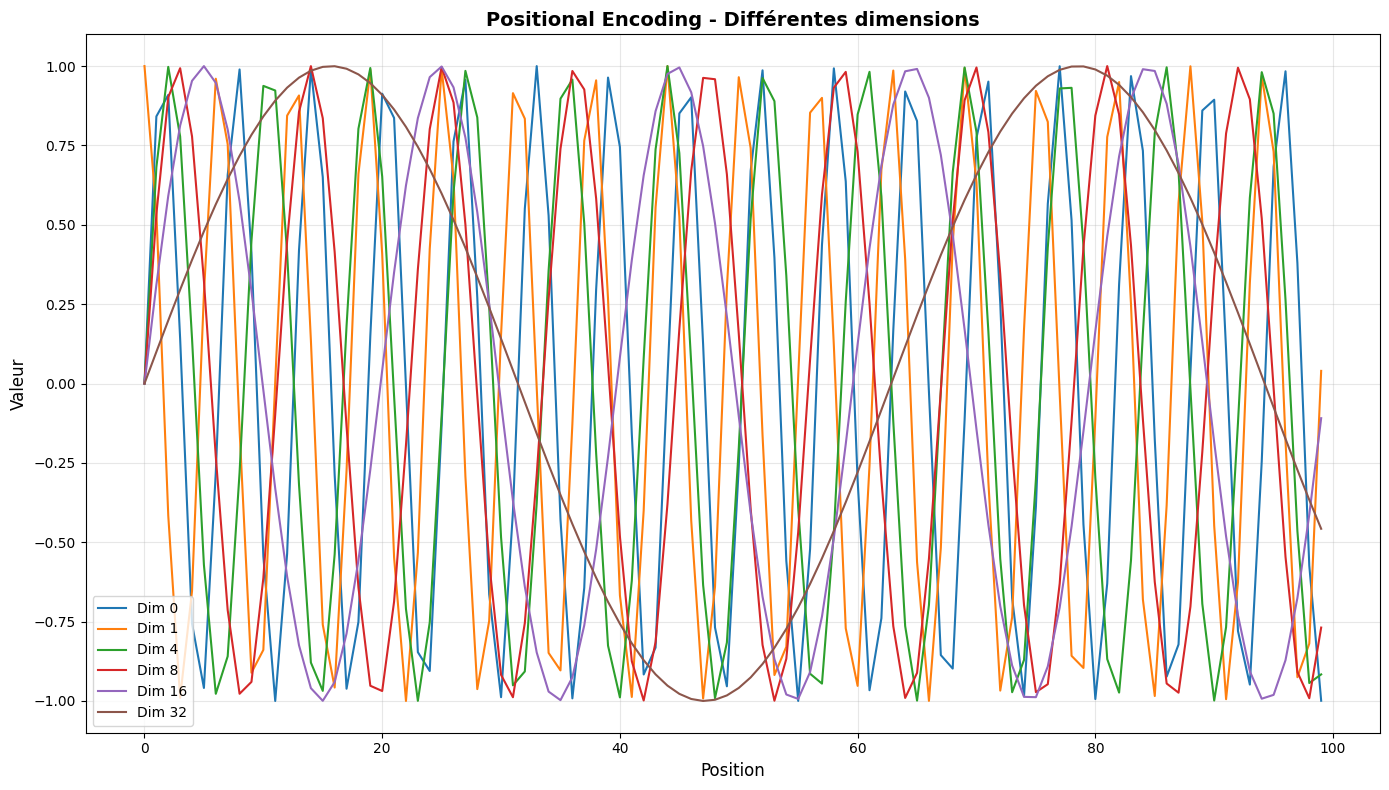

Les dimensions basses (0,1) oscillent rapidement
Les dimensions hautes (32) oscillent lentement
→ Capture des patterns à différentes échelles!


In [11]:
# Tracer quelques dimensions spécifiques
dimensions_to_plot = [0, 1, 4, 8, 16, 32]

plt.figure(figsize=(14, 8))
for dim in dimensions_to_plot:
    if dim < d_model_viz:
        plt.plot(PE_viz[:, dim].numpy(), label=f'Dim {dim}')

plt.xlabel('Position', fontsize=12)
plt.ylabel('Valeur', fontsize=12)
plt.title('Positional Encoding - Différentes dimensions', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("Les dimensions basses (0,1) oscillent rapidement")
print("Les dimensions hautes (32) oscillent lentement")
print("→ Capture des patterns à différentes échelles!")

## 4. Classe PositionalEncoding

In [12]:
class PositionalEncoding(nn.Module):
    """
    Positional Encoding pour Transformer
    """
    
    def __init__(self, d_model, max_sequence_length=5000):
        super().__init__()
        self.d_model = d_model
        self.max_sequence_length = max_sequence_length
        
        # Pré-calculer les PE pour toutes les positions
        pe = torch.zeros(max_sequence_length, d_model)
        
        position = torch.arange(0, max_sequence_length).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * 
                            (-math.log(10000.0) / d_model))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        
        # Enregistrer comme buffer (pas un paramètre à entraîner)
        self.register_buffer('pe', pe)
    
    def forward(self, x):
        """
        Args:
            x: (batch_size, seq_len, d_model)
        Returns:
            x + positional encoding
        """
        seq_len = x.size(1)
        x = x + self.pe[:seq_len, :].unsqueeze(0)
        return x

print("✓ Classe PositionalEncoding définie")

✓ Classe PositionalEncoding définie


## 5. Test de la classe

In [13]:
# Créer une instance
pe_layer = PositionalEncoding(d_model=512, max_sequence_length=100)

# Données de test (embeddings)
batch_size = 2
seq_len = 10
d_model = 512

x = torch.randn(batch_size, seq_len, d_model)

print(f"Input shape: {x.shape}")

# Ajouter le positional encoding
x_with_pe = pe_layer(x)

print(f"Output shape: {x_with_pe.shape}")
print(f"\n✓ Le positional encoding a été ajouté!")

Input shape: torch.Size([2, 10, 512])
Output shape: torch.Size([2, 10, 512])

✓ Le positional encoding a été ajouté!


## 6. Comparaison: Avant/Après Positional Encoding

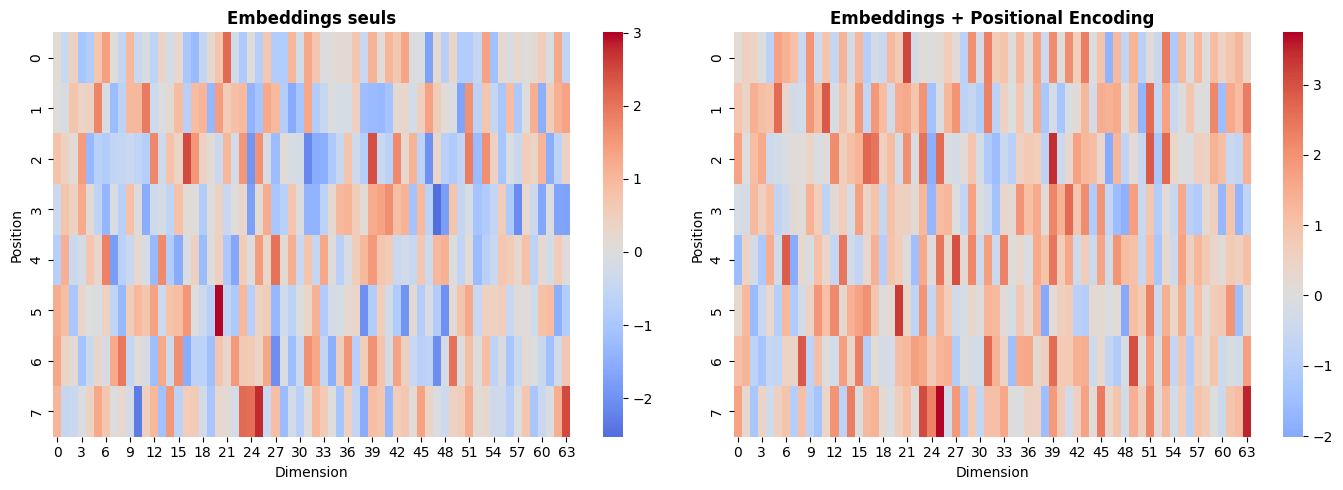

Le PE ajoute des patterns de position distincts à chaque token!


In [14]:
# Embeddings simples (sans PE)
simple_embeddings = torch.randn(1, 8, 64)

# Avec PE
pe_layer_small = PositionalEncoding(d_model=64)
embeddings_with_pe = pe_layer_small(simple_embeddings)

# Visualisation
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.heatmap(simple_embeddings.squeeze(0).numpy(), cmap='coolwarm', 
            center=0, ax=axes[0])
axes[0].set_title('Embeddings seuls', fontweight='bold')
axes[0].set_xlabel('Dimension')
axes[0].set_ylabel('Position')

sns.heatmap(embeddings_with_pe.squeeze(0).detach().numpy(), cmap='coolwarm',
            center=0, ax=axes[1])
axes[1].set_title('Embeddings + Positional Encoding', fontweight='bold')
axes[1].set_xlabel('Dimension')
axes[1].set_ylabel('Position')

plt.tight_layout()
plt.show()

print("Le PE ajoute des patterns de position distincts à chaque token!")

## 7. Propriété importante: Distance relative

=== Similarité entre positions ===
Position 0 vs 1:  0.9702
Position 0 vs 5:  0.7373
Position 0 vs 10: 0.6691
Position 0 vs 20: 0.6083

✓ La similarité diminue avec la distance!


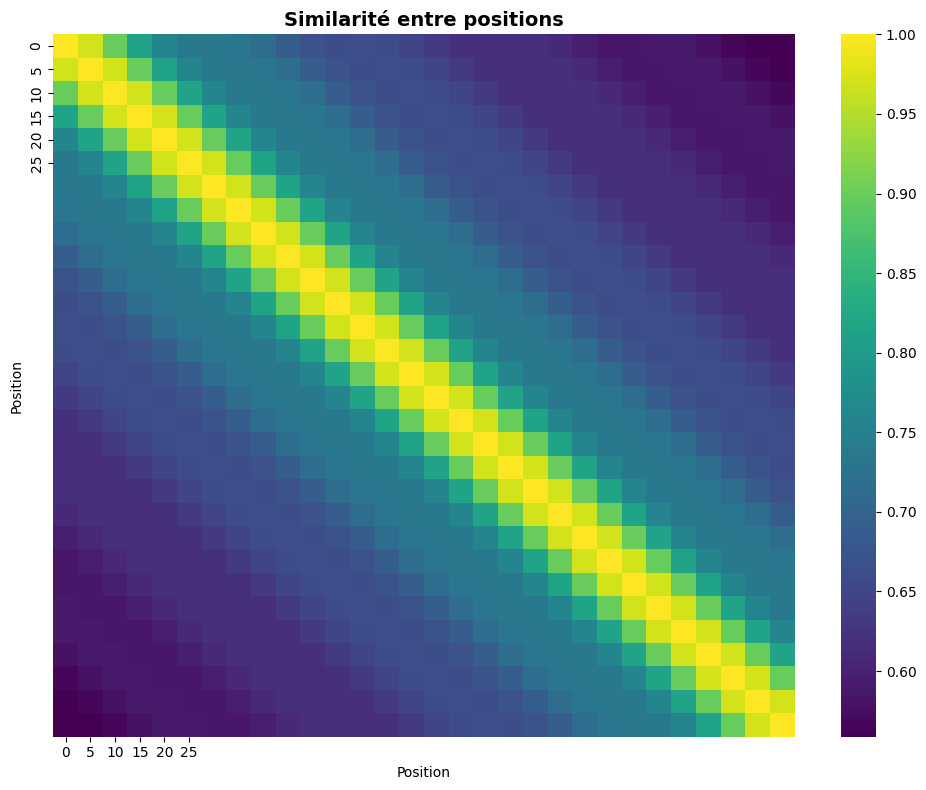

In [15]:
# Le PE permet de capturer les distances relatives
pe_test = PositionalEncoding(d_model=128, max_sequence_length=50)

# Produit scalaire entre différentes positions
pos_0 = pe_test.pe[0]
pos_1 = pe_test.pe[1]
pos_5 = pe_test.pe[5]
pos_10 = pe_test.pe[10]
pos_20 = pe_test.pe[20]

# Similarité cosinus
def cosine_similarity(a, b):
    return torch.dot(a, b) / (torch.norm(a) * torch.norm(b))

print("=== Similarité entre positions ===")
print(f"Position 0 vs 1:  {cosine_similarity(pos_0, pos_1):.4f}")
print(f"Position 0 vs 5:  {cosine_similarity(pos_0, pos_5):.4f}")
print(f"Position 0 vs 10: {cosine_similarity(pos_0, pos_10):.4f}")
print(f"Position 0 vs 20: {cosine_similarity(pos_0, pos_20):.4f}")
print(f"\n✓ La similarité diminue avec la distance!")

# Heatmap de similarité
n_pos = 30
similarity_matrix = torch.zeros(n_pos, n_pos)
for i in range(n_pos):
    for j in range(n_pos):
        similarity_matrix[i, j] = cosine_similarity(pe_test.pe[i], pe_test.pe[j])

plt.figure(figsize=(10, 8))
sns.heatmap(similarity_matrix.numpy(), cmap='viridis', 
            xticklabels=range(0, n_pos, 5),
            yticklabels=range(0, n_pos, 5))
plt.title('Similarité entre positions', fontsize=14, fontweight='bold')
plt.xlabel('Position')
plt.ylabel('Position')
plt.tight_layout()
plt.show()

## 8. Alternatives au Positional Encoding

In [16]:
class LearnedPositionalEncoding(nn.Module):
    """
    Alternative: Apprendre les positional encodings
    (utilisé par BERT)
    """
    
    def __init__(self, d_model, max_sequence_length):
        super().__init__()
        self.pe = nn.Parameter(torch.randn(max_sequence_length, d_model))
    
    def forward(self, x):
        seq_len = x.size(1)
        return x + self.pe[:seq_len, :].unsqueeze(0)

# Comparaison
print("=== Comparaison PE ===")
print("\n1. Sinusoidal PE (Transformer original):")
print("   ✓ Pas de paramètres à apprendre")
print("   ✓ Peut gérer des séquences plus longues que celles vues en training")
print("   ✓ Propriétés mathématiques utiles")

print("\n2. Learned PE (BERT):")
print("   ✓ Plus flexible")
print("   ✗ Limité aux longueurs vues en training")
print("   ✓ Peut apprendre des patterns spécifiques à la tâche")

print("\n3. Relative PE (Transformer-XL):")
print("   ✓ Se concentre sur les distances relatives")
print("   ✓ Meilleur pour les longues séquences")

=== Comparaison PE ===

1. Sinusoidal PE (Transformer original):
   ✓ Pas de paramètres à apprendre
   ✓ Peut gérer des séquences plus longues que celles vues en training
   ✓ Propriétés mathématiques utiles

2. Learned PE (BERT):
   ✓ Plus flexible
   ✗ Limité aux longueurs vues en training
   ✓ Peut apprendre des patterns spécifiques à la tâche

3. Relative PE (Transformer-XL):
   ✓ Se concentre sur les distances relatives
   ✓ Meilleur pour les longues séquences


## Résumé

### Pourquoi le Positional Encoding?
L'attention est **permutation-invariante**: elle ne voit pas l'ordre des mots. Le PE injecte l'information de position.

### Comment ça marche?
- **Sinusoïdes** de fréquences différentes
- Dimensions basses = haute fréquence (relations locales)
- Dimensions hautes = basse fréquence (relations globales)

### Formule:
$$PE_{(pos, 2i)} = \sin\left(\frac{pos}{10000^{2i/d_{model}}}\right)$$
$$PE_{(pos, 2i+1)} = \cos\left(\frac{pos}{10000^{2i/d_{model}}}\right)$$

### Propriétés clés:
1. **Unique** pour chaque position
2. **Déterministe** (pas de paramètres)
3. **Extrapolable** à des longueurs non vues
4. **Distance relative** encodée naturellement

### Usage:
```python
embeddings = token_embedding(tokens)  # (batch, seq, d_model)
embeddings = positional_encoding(embeddings)  # Ajoute PE
```